In [1]:
import torch
from torcheval.metrics.functional import binary_accuracy
import matplotlib.pyplot as plt
import numpy as np
# Add the directory above the current notebook's directory to the system path
import sys
import os
sys.path.append(os.path.join(os.getcwd(), '..'))
from datasets import load_flower_dataset

### PLot functions

In [2]:
def plot_scatter(X:np.ndarray, Y:np.ndarray):
    '''
    Show the scatter plot of flower dataset
    
    Parameters
    ----------
    X : numpy.ndarray [shape: (#features, #samples)]
        matrix of data; dtype: float64
    Y : numpy.ndarray [shape: (1, #samples)]
        array containing true labels 0 or 1; dtype: uint8 
    '''
    scatter=plt.scatter(X[0, :], X[1, :], c=Y, s=40, cmap=plt.cm.Spectral)
    plt.legend(*scatter.legend_elements(), loc="upper right", title="Classes")
    plt.xlabel('feature 1')
    plt.ylabel('feature 2')
    # plt.show()
    

def plot_decision_boundary(predict, X, Y):
    """
    Plot the decision boundary for logistic regression
    
    Parameters
    ----------
    predict : function
        predicted output; dtype=int8 
    parameters : dict
    X : numpy.ndarray [shape: (#features, #samples)]
        matrix of data; dtype: float64
    Y : numpy.ndarray [shape: (1, #samples)]
        array containing true labels 0 or 1; dtype: uint8
    """
    # Set min and max values and give it some padding
    x_min, x_max = X[0, :].min() - 1, X[0, :].max() + 1
    y_min, y_max = X[1, :].min() - 1, X[1, :].max() + 1
    h = 0.01
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole grid
    # Y = None argument is dumpy as not used when print_accuracy=False
    Z = predict(torch.tensor(np.c_[xx.ravel(), yy.ravel()],dtype=torch.float32))
    Z=(Z > 0.5).type(torch.float32)
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plot_scatter(X,Y)

### Import data

torch.Size([500, 2]) torch.Size([500, 1])


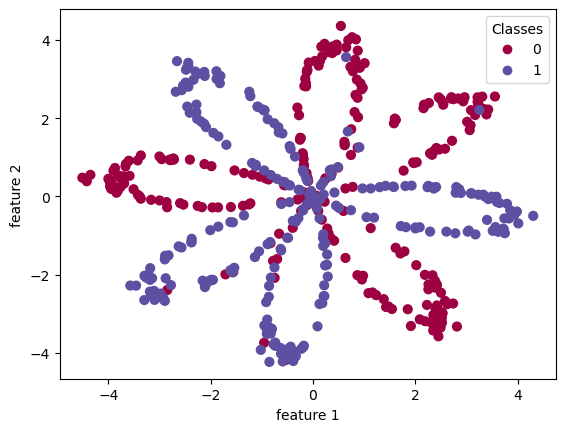

In [3]:
X_np,Y_np = load_flower_dataset( petals=4, noise=0.2, angle=30)
X=torch.tensor(X_np.T, dtype=torch.float32)
Y=torch.tensor(Y_np.reshape(-1,1), dtype=torch.float32)
print(X.shape, Y.shape)
plot_scatter(X_np,Y_np)

### L Layer Neural Network Model

In [4]:
def L_layer_model(train_X, train_Y, layers_dims, learning_rate=0.0075, num_epochs=2000, activation_L_1="relu", activation_L="sigmoid", print_cost=False):
    """
    L layer neural network with different activation function on output layer option.
    
    Parameters
    ----------
    train_X : Tensor [shape: (#samples, #features)]; dtype=tf.float32
    train_Y : Tensor [shape: (#samples, 1)]; dtype=tf.float32
    layers_dims : list of int; list of number of nodes in each layer

    Returns
    -------
    forward : trained model
    costs : list of cost every 100 iteration
    """
    costs = []                                        # To keep track of the cost
    L = len(layers_dims) # number of layers in the network

    ## Initialize layers
    activations = torch.nn.ModuleDict({ 'sigmoid':torch.nn.Sigmoid(), 'tanh':torch.nn.Tanh(),
                'relu':torch.nn.ReLU(), 'lrelu':torch.nn.LeakyReLU() })
    layers_list = []
    for in_f, out_f in zip(layers_dims, layers_dims[1:-1]):
        layers_list.append(torch.nn.Linear(in_f, out_f))
        layers_list.append(activations[activation_L_1])
    layers_list.append(torch.nn.Linear(layers_dims[-2], layers_dims[-1]))
    layers_list.append(activations[activation_L])
        
    forward = torch.nn.Sequential(*layers_list)
    
    ## Initialize parameters
    np.random.seed(3)
    with torch.no_grad():
        for l in range(1, L):
            init_W = torch.tensor( np.random.randn(layers_dims[l], layers_dims[l-1]) / np.sqrt(layers_dims[l-1]), dtype=torch.float32 )
            init_b = torch.zeros((layers_dims[l], ))
            forward[2*(l-1)].weight.copy_(init_W)
            forward[2*(l-1)].bias.copy_(init_b)
            
    optimizer = torch.optim.Adam(forward.parameters(), lr = learning_rate)

    ## epochs loop
    for i in range(num_epochs): 
        ## forward pass
        train_Y_pred = forward(train_X)       # (209,n_L)=(m,n_L)
        cost = torch.nn.functional.binary_cross_entropy(train_Y_pred, train_Y, reduction="mean")

        ## backward pass
        optimizer.zero_grad()
        cost.backward()
        optimizer.step()

        ## Record the cost every 100 iterations
        if i % 100 == 0 or i == num_epochs-1:
            costs.append(cost.item())
            if print_cost:
                print(f"Cost in epochs {i+1}, {cost.item()}")
    
    return forward, costs


def plot_costs(costs, learning_rate):
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per hundreds)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()

### Detailed info, plots demo

Cost in epochs 1, 0.812698483467102
Cost in epochs 101, 0.29724425077438354
Cost in epochs 201, 0.22785831987857819
Cost in epochs 301, 0.20931829512119293
Cost in epochs 401, 0.19939234852790833
Cost in epochs 501, 0.193834587931633
Cost in epochs 601, 0.18984955549240112
Cost in epochs 701, 0.1866236925125122
Cost in epochs 801, 0.18386931717395782
Cost in epochs 901, 0.18131953477859497
Cost in epochs 1001, 0.1789415031671524
Cost in epochs 1101, 0.17631779611110687
Cost in epochs 1201, 0.17432467639446259
Cost in epochs 1301, 0.17263250052928925
Cost in epochs 1401, 0.1707601696252823
Cost in epochs 1501, 0.16823378205299377
Cost in epochs 1601, 0.16606464982032776
Cost in epochs 1701, 0.1646013855934143
Cost in epochs 1801, 0.1634196937084198
Cost in epochs 1901, 0.1623488813638687
Cost in epochs 2000, 0.16166847944259644
train accuracy: 94.19999718666077 %


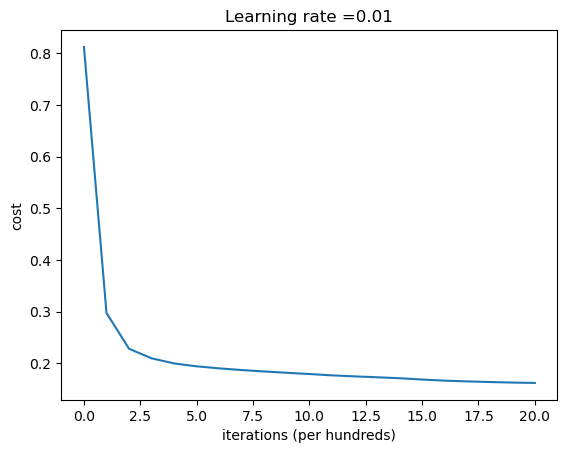

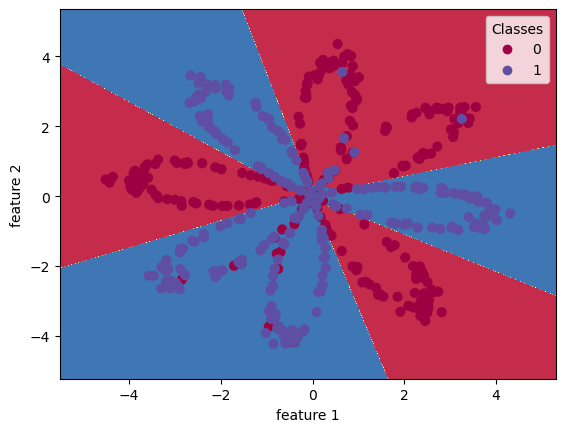

In [5]:
num_epochs=2000; activation_L_1="relu"; activation_L="sigmoid"
learning_rate = 0.01; layers_dims=[X.shape[-1],6,6, 1]

forward, costs = L_layer_model(X, Y, layers_dims, learning_rate, num_epochs, activation_L_1, activation_L, print_cost=True)
Y_pred=forward(X)
acc = binary_accuracy(input=Y_pred.view(-1,), target=Y.view(-1,), threshold=0.5)
print(f"train accuracy: { acc.item() *100 } %")
plot_costs(costs, learning_rate)
plot_decision_boundary(forward, X_np, Y_np)

### Single Neuron Model Run

Cost in epochs 1, 1.5223278999328613
Cost in epochs 101, 0.7630832195281982
Cost in epochs 201, 0.6634264588356018
Cost in epochs 301, 0.6622133255004883
Cost in epochs 401, 0.6622119545936584
Cost in epochs 501, 0.6622120141983032
Cost in epochs 601, 0.6622120141983032
Cost in epochs 701, 0.6622120141983032
Cost in epochs 801, 0.6622120141983032
Cost in epochs 901, 0.6622120141983032
Cost in epochs 1001, 0.6622120141983032
Cost in epochs 1101, 0.6622120141983032
Cost in epochs 1201, 0.6622120141983032
Cost in epochs 1301, 0.6622120141983032
Cost in epochs 1401, 0.6622120141983032
Cost in epochs 1501, 0.6622120141983032
Cost in epochs 1601, 0.6622120141983032
Cost in epochs 1701, 0.6622120141983032
Cost in epochs 1801, 0.6622120141983032
Cost in epochs 1901, 0.6622120141983032
Cost in epochs 2000, 0.6622120141983032
train accuracy: 47.200000286102295 %


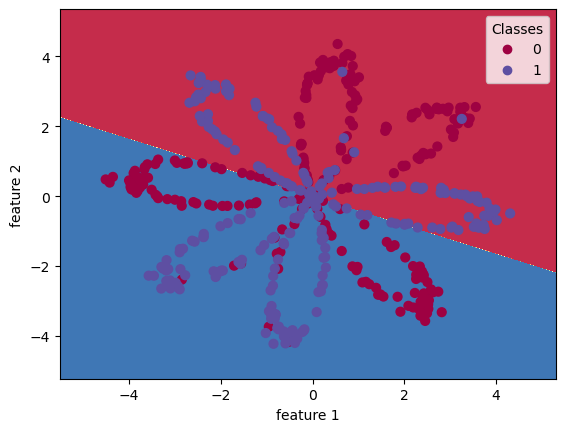

In [6]:
num_epochs=2000; activation_L_1="relu"; activation_L="sigmoid"
learning_rate = 0.01; layers_dims=[X.shape[-1], 1]

forward, costs = L_layer_model(X, Y, layers_dims, learning_rate, num_epochs, activation_L_1, activation_L, print_cost=True)
Y_pred=forward(X)
acc = binary_accuracy(input=Y_pred.view(-1,), target=Y.view(-1,), threshold=0.5)
print(f"train accuracy: { acc.item() *100 } %")
plot_decision_boundary(forward, X_np, Y_np)

### 2 Layers (or 1 hidden layer) Neural Network with 1 neuron in output layer

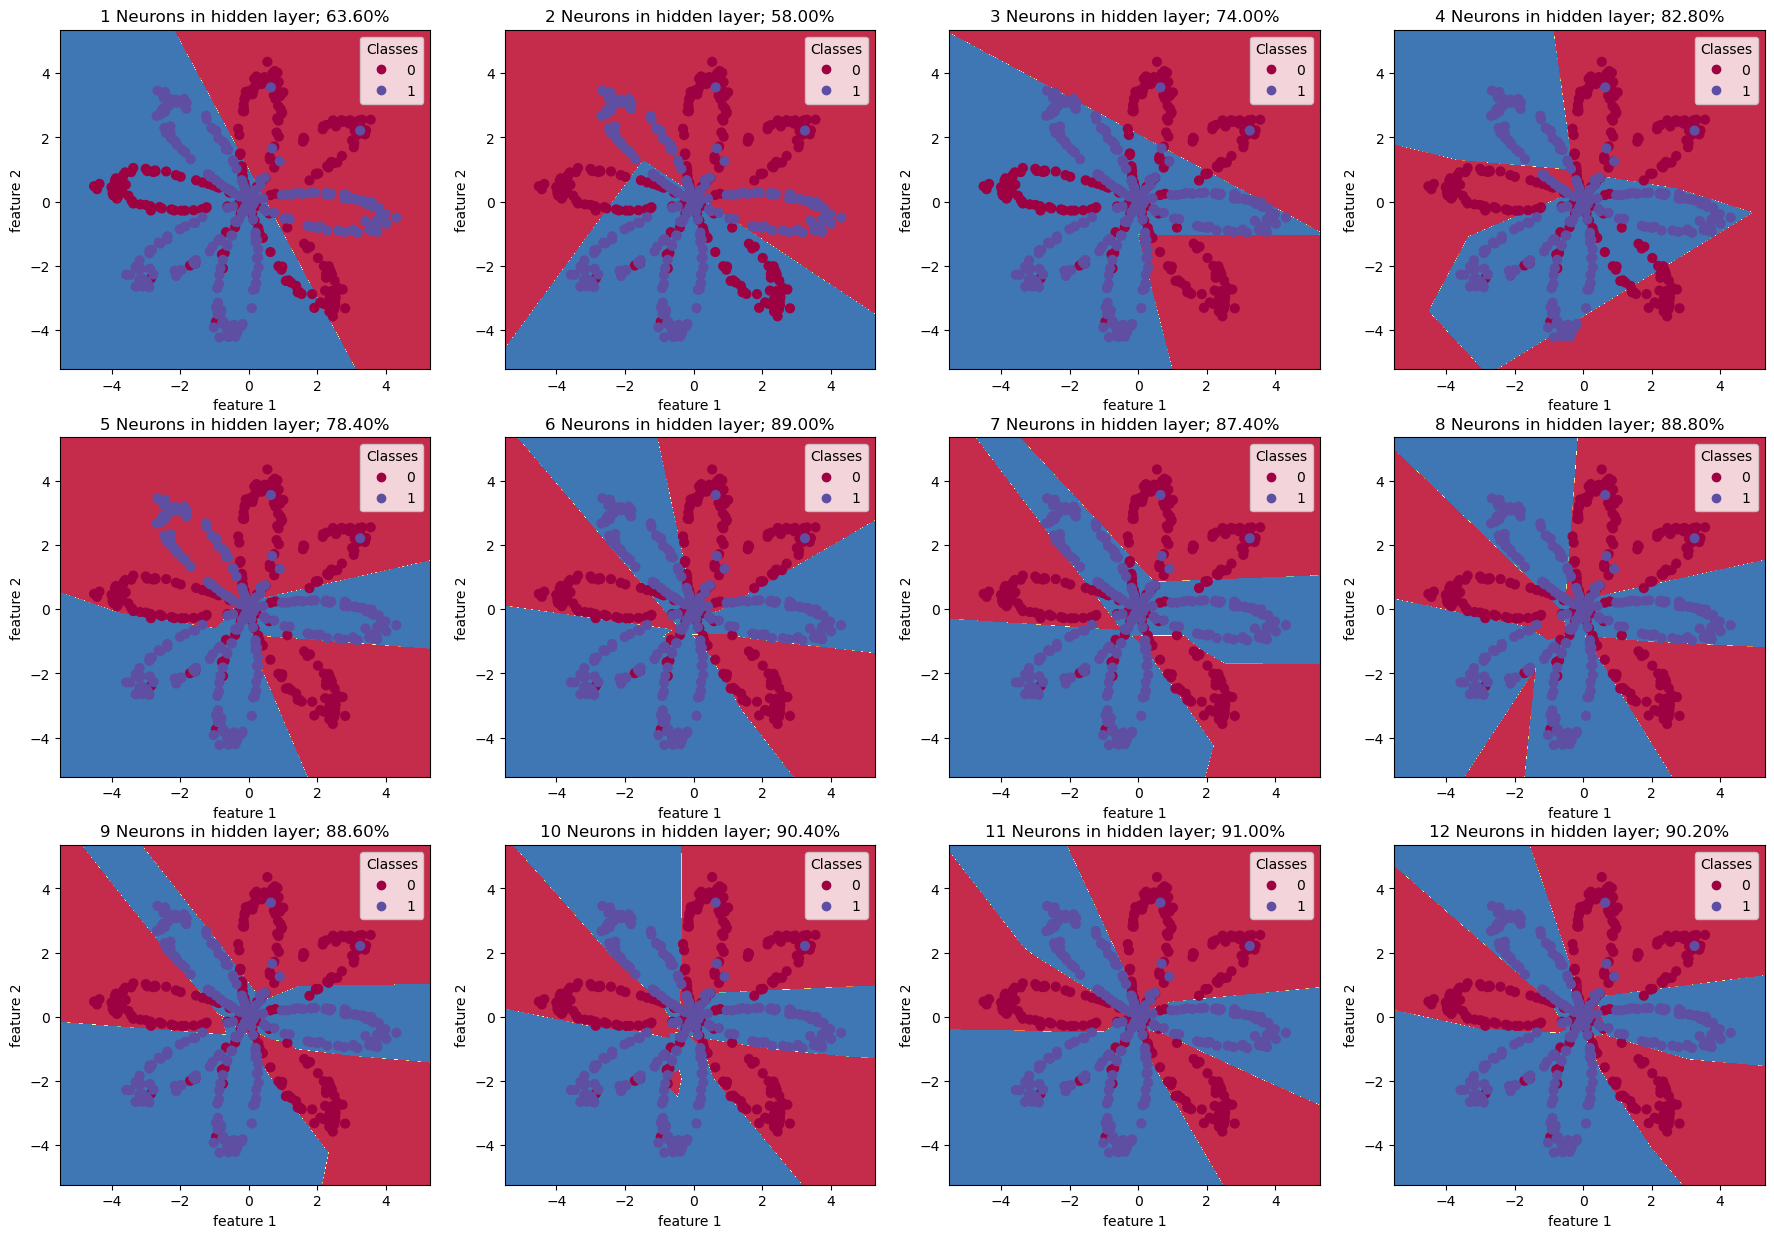

In [7]:
num_epochs=2000; activation_L_1="relu"; activation_L="sigmoid"
learning_rate = 0.01; layers_dims=[X.shape[-1],1, 1]
plt.rcParams['figure.figsize'] = (22.0, 15.0) # width, height
for i in range(1,13):
    layers_dims=[X.shape[-1],i, 1]
    plt.subplot(3, 4, i)
    forward, costs = L_layer_model(X, Y, layers_dims, learning_rate, num_epochs, activation_L_1, activation_L, print_cost=False)
    Y_pred=forward(X)
    acc = binary_accuracy(input=Y_pred.view(-1,), target=Y.view(-1,), threshold=0.5)
    plot_decision_boundary(forward, X_np, Y_np)
    plt.title(f"{i} Neurons in hidden layer; {acc.item()*100:.2f}%")


### 3 Layers (or 2 hidden layer) Neural Network with 1 neuron in output layer

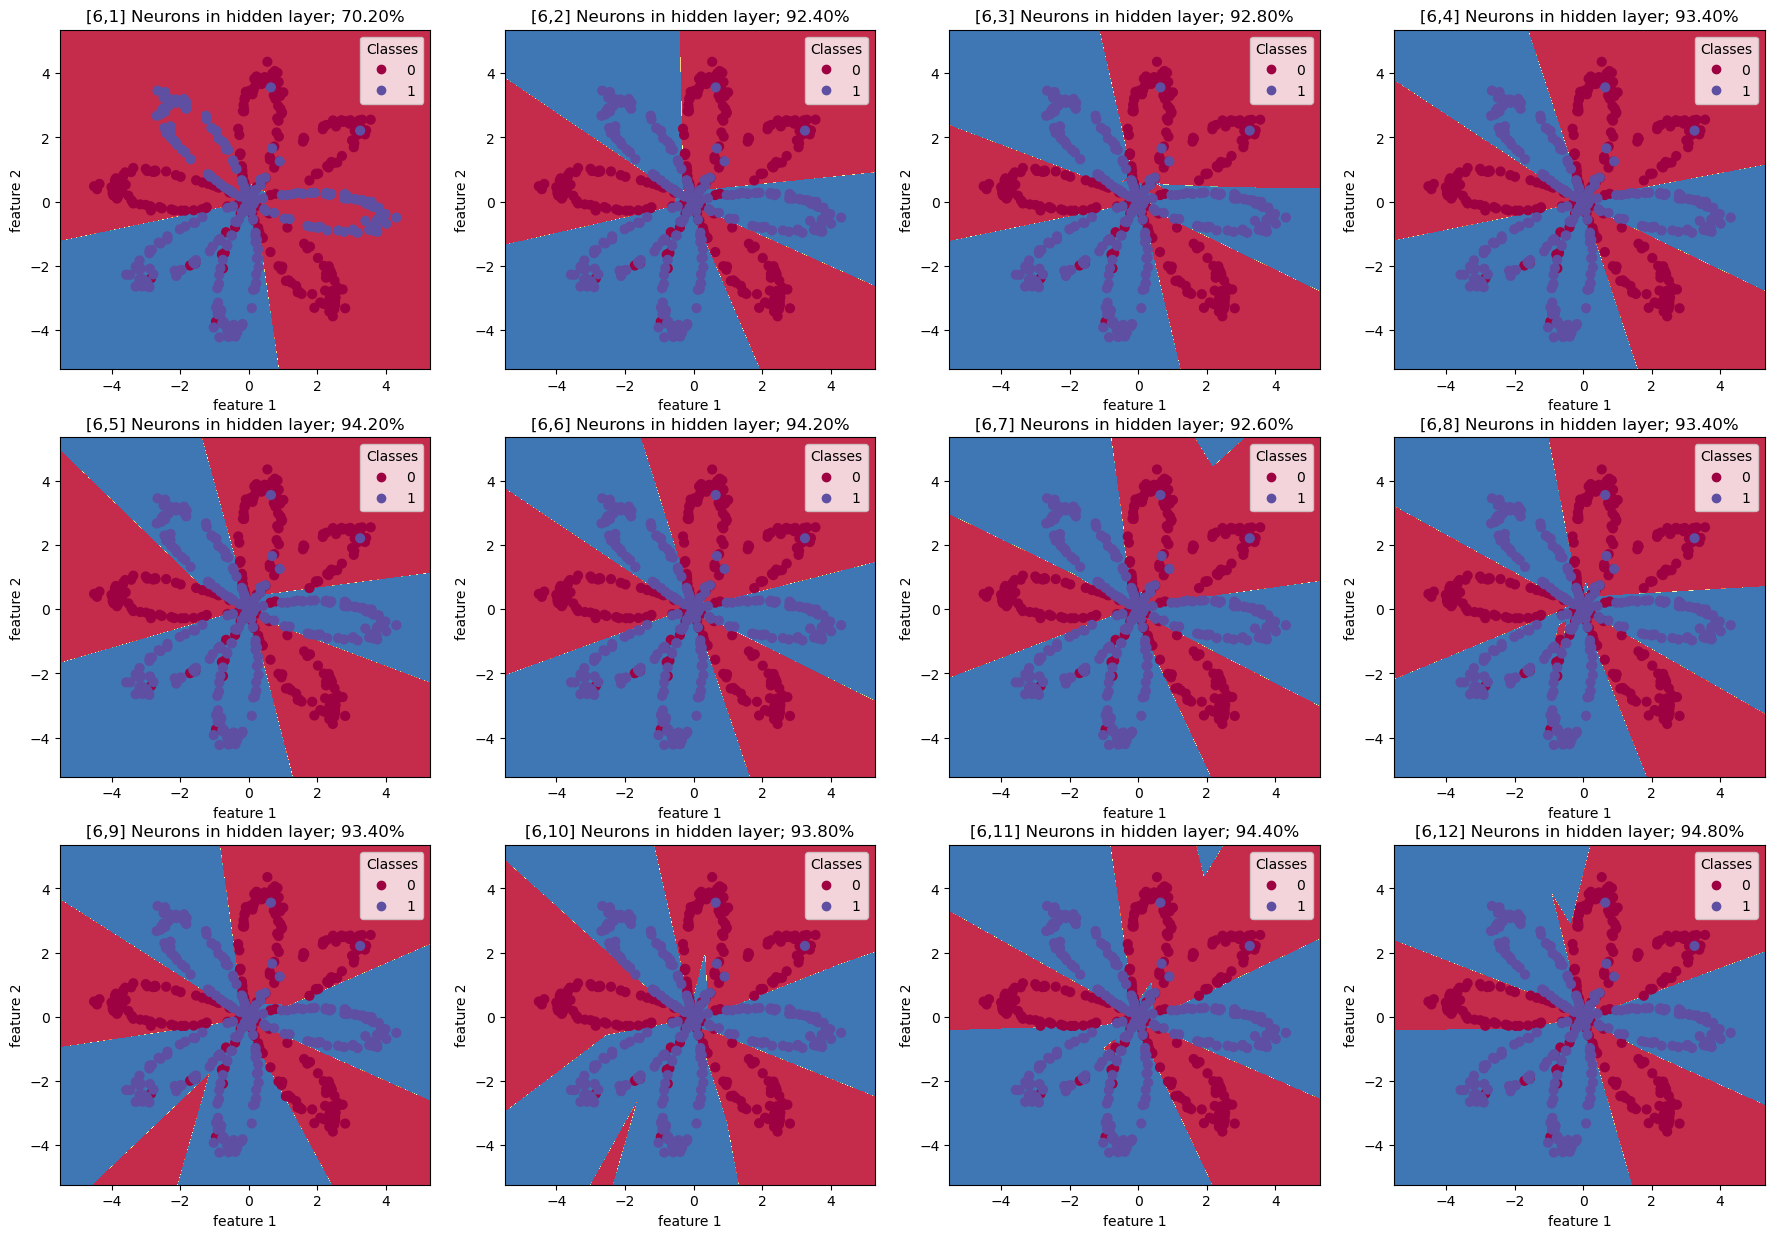

In [8]:
num_epochs=2000; activation_L_1="relu"; activation_L="sigmoid"
learning_rate = 0.01; layers_dims=[X.shape[-1],6,1, 1]
plt.rcParams['figure.figsize'] = (22.0, 15.0) # width, height
for i in range(1,13):
    layers_dims=[X.shape[-1],6, i, 1]
    plt.subplot(3, 4, i)
    forward, costs = L_layer_model(X, Y, layers_dims, learning_rate, num_epochs, activation_L_1, activation_L, print_cost=False)
    Y_pred=forward(X)
    acc = binary_accuracy(input=Y_pred.view(-1,), target=Y.view(-1,), threshold=0.5)
    plot_decision_boundary(forward, X_np, Y_np)
    plt.title(f"[6,{i}] Neurons in hidden layer; {acc.item()*100:.2f}%")

### 4 Layers (or 3 hidden layer) Neural Network with 1 neuron in output layer

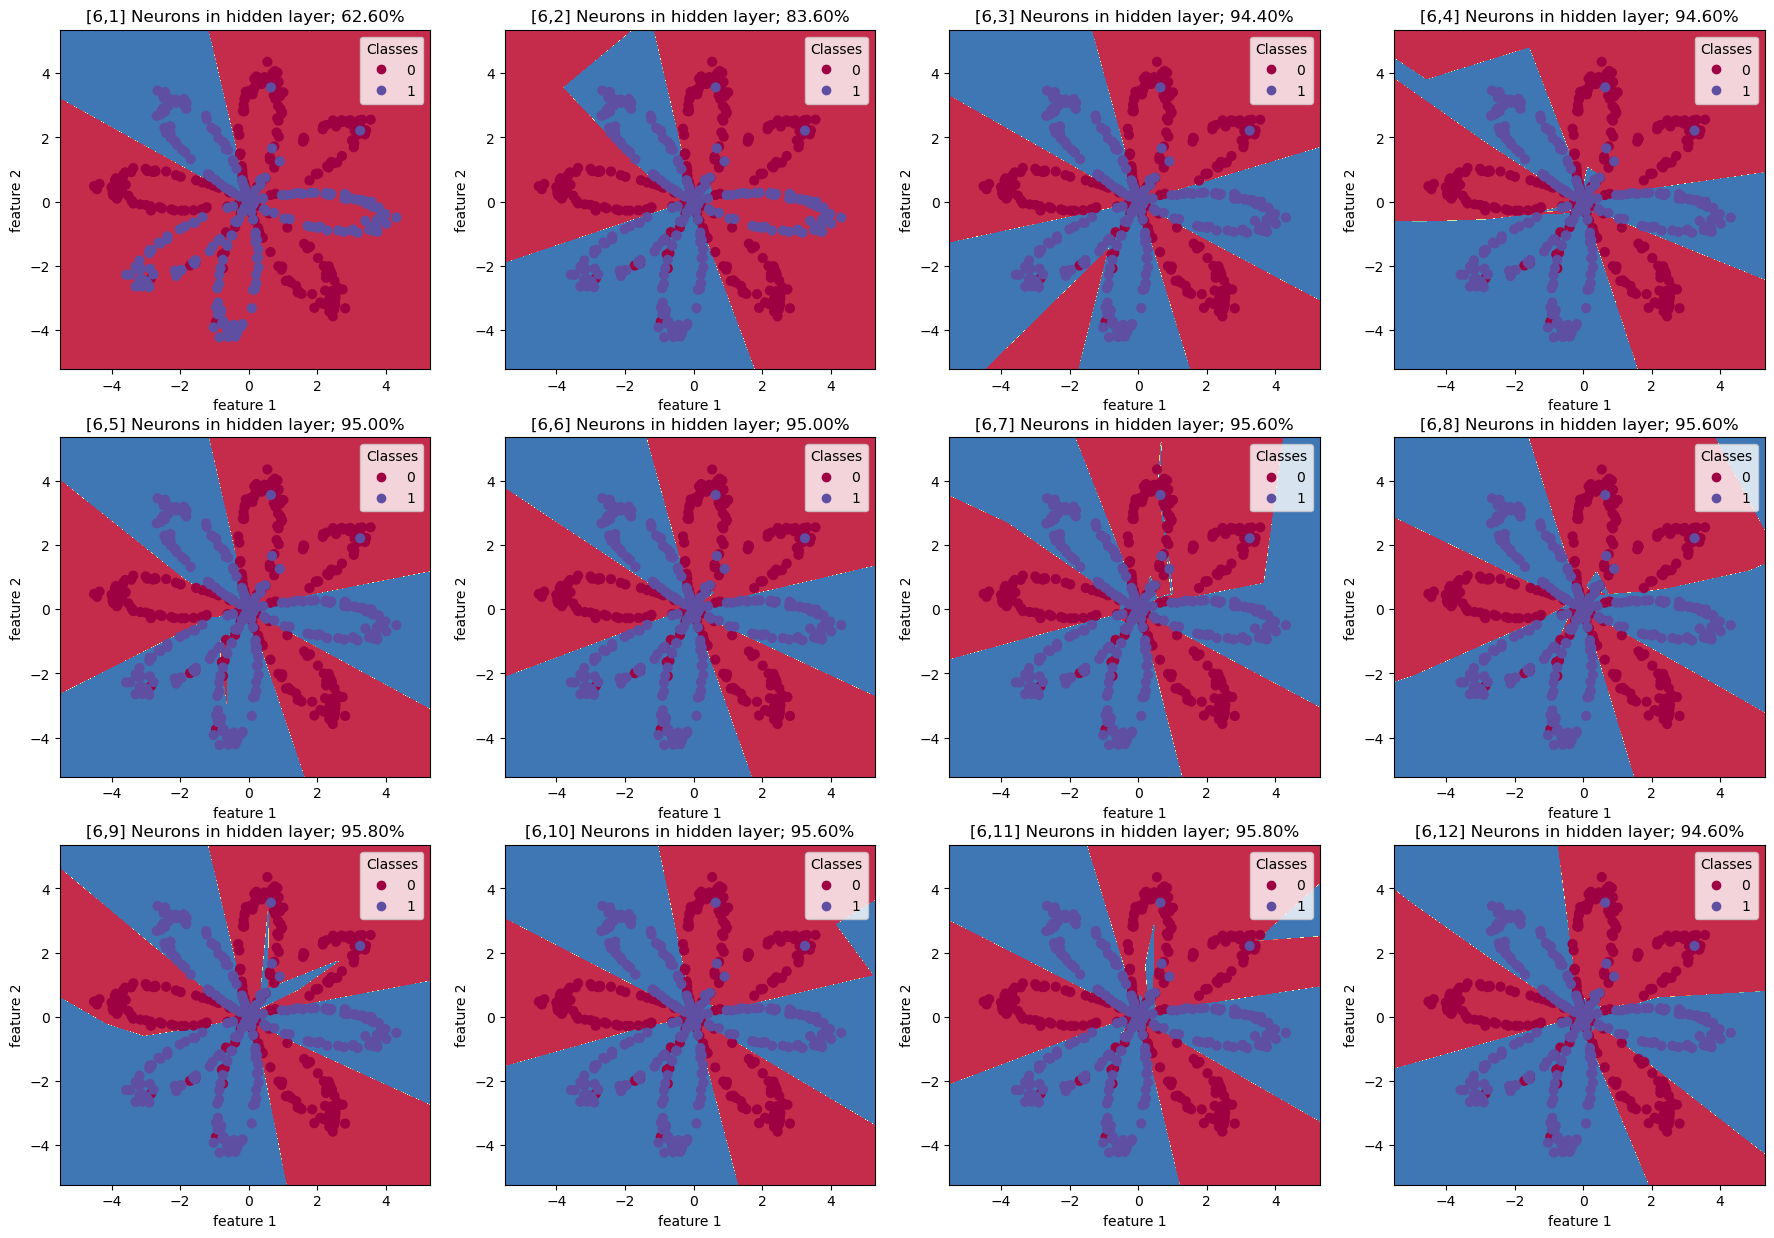

In [9]:
num_epochs=2000; activation_L_1="relu"; activation_L="sigmoid"
learning_rate = 0.01; layers_dims=[X.shape[-1],6,6,1, 1]
plt.rcParams['figure.figsize'] = (22.0, 15.0) # width, height
for i in range(1,13):
    layers_dims=[X.shape[-1],6,6, i, 1]
    plt.subplot(3, 4, i)
    forward, costs = L_layer_model(X, Y, layers_dims, learning_rate, num_epochs, activation_L_1, activation_L, print_cost=False)
    Y_pred=forward(X)
    acc = binary_accuracy(input=Y_pred.view(-1,), target=Y.view(-1,), threshold=0.5)
    plot_decision_boundary(forward, X_np, Y_np)
    plt.title(f"[6,{i}] Neurons in hidden layer; {acc.item()*100:.2f}%")

### Conclusion

3 layer neural networks in general give best results and adding more layers is increasing accuracy by much but probably overfitting.

Text(0.5, 1.0, '[6,6] Neurons in hidden layer; 94.20%')

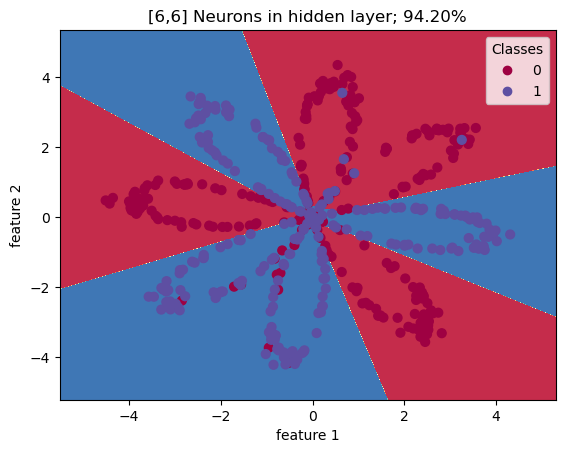

In [10]:
num_epochs=2000; activation_L_1="relu"; activation_L="sigmoid"
learning_rate = 0.01; layers_dims=[X.shape[-1],6,6, 1]
plt.rcParams["figure.figsize"] = plt.rcParamsDefault["figure.figsize"]
forward, costs = L_layer_model(X, Y, layers_dims, learning_rate, num_epochs, activation_L_1, activation_L, print_cost=False)
Y_pred=forward(X)
acc = binary_accuracy(input=Y_pred.view(-1,), target=Y.view(-1,), threshold=0.5)
# print(f"train accuracy: { acc.item() *100 } %")
# plot_costs(costs, learning_rate)
plot_decision_boundary(forward, X_np, Y_np)
plt.title(f"[6,6] Neurons in hidden layer; {acc.item()*100:.2f}%")